# Implementation of the Page Rank Algorithm + Bonus Question

---
#### Course: Computational Data Mining
#### Professor: Dr. Fatemeh Shakeri
#### Student: Ilya Khalafi
#### Student ID: 9913039
#### December 2023

# Table Of Contents
- [Introduction](#intro)
- [Dependencies](#dependency)
- [Importing the Dataset](#dataset)
- [Challenges](#challenges)
  - [Implementation of the Page Rank](#implementation)
  - [Applying the Page Rank](#apply)
- [Bonus Problem](#bonus)

<a name="intro"></a>

# Introduction 📚

---

One of the interesting probabilistics models are Markov Decision Processes (MDP). MDPs are applicable to several real-world conditions. In fact, wherever there is a combination of state and probabilistic transition, we can model our environment as a MDP.

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400"/>

One of the exciting real world MDPs is internet's webapges! Each page is considered to be a state, then there are edges to other nodes with a given probability. In order to rank webpage, we assume users go around inside this MDP; therefore, from somewhere, we expect to see a constant and specific amount of users visiting each page. This is called **stationary distribution** of our MDP. From an linear algebraic point of view, stationary distribution is simply the eigenvector of the transition matrix of our nodes, were transition matrix is like adjacency matrix of MDP if we consider our MDP as a weighted graph and consider probabilities as weights of edges.

In this article, we implement the Page Rank Algorithm, which briefly utilizes the Power Method to calculate the eigenvectors of our transition matrix (stationary distribution of MDP). Then we use the value of each state in the eigenvector to rank states of our MDP (webpages of internet).

<a name="dependency"></a>

#Dependencies 🧰

---

We need the following libraries during this article:

- **numpy** : <br />
    numpy is a commonly used library for doing scientific computation. Unlike python default pointer structure, numpy saves variables inplace and continous on RAM and also provides sophisticated methods that use parallelism to make our computations much faster.

- **pandas**: <br />
    pandas is well-known in data science for its useful methods for reading and manipulating the data.

- **scipy**: <br />
    As numpy is specialized for numerical computation, scipy is specialized for scientific computation. It contains several useful methods that are not present inside numpy. We will use its CSR class for representing our sparse matrices.


In [1]:
%%capture
# Fundamental Data Analysis & Visualization Tools
import numpy as np
import pandas as pd
from scipy.sparse import csr_array

<a name="dataset"></a>

#Importing the Dataset 🔽

---

Here we download the **sklearn-anatomy** dataset from my google drive, then we import it using the pandas library.

In [2]:
# Downloading the dataset
!gdown '1wVWN1TmopEjSOQhC76I4cPUgK-iEadzD'

Downloading...
From: https://drive.google.com/uc?id=1wVWN1TmopEjSOQhC76I4cPUgK-iEadzD
To: /content/sklearn-anatomy.csv
100% 17.8M/17.8M [00:00<00:00, 117MB/s] 


In [3]:
# Importing the dataset
df = pd.read_csv('sklearn-anatomy.csv', dtype=str)
# Taking a look into the dataset...
df.head(5)

,page_url,page_title,page_length,link_text,link_href,link_url
0,https://scikit-learn.org/stable/index.html,scikit-learn: machine learning in Python — sci...,27767,Install,install.html,https://scikit-learn.org/stable/install.html
1,https://scikit-learn.org/stable/index.html,scikit-learn: machine learning in Python — sci...,27767,User Guide,user_guide.html,https://scikit-learn.org/stable/user_guide.html
2,https://scikit-learn.org/stable/index.html,scikit-learn: machine learning in Python — sci...,27767,API,modules/classes.html,https://scikit-learn.org/stable/modules/classe...
3,https://scikit-learn.org/stable/index.html,scikit-learn: machine learning in Python — sci...,27767,Examples,auto_examples/index.html,https://scikit-learn.org/stable/auto_examples/...
4,https://scikit-learn.org/stable/index.html,scikit-learn: machine learning in Python — sci...,27767,Community,https://blog.scikit-learn.org/,https://blog.scikit-learn.org/


It seems that each row contains a hyperlink from a webpage to another webpage. The "page_url" contains the urls of the page that contains the hyperlink and "link_url" contains the link of the referred page. We do not need other columns; therefore, here is how we clean our data and build the dataset:
- 1) Only keep the first and last columns (origin and destination of an edge)
- 2) Make a dictionary of all webpages to their indexes (nodes of the graph)
- 3) Consider a zero matrix where each webpage has a row and a columns in the matrix
- 4) Replace the address of each webpage with its index in the matrix
- 5) For each element (i, j), add it by 1 unit if there is an edge from the page (node) j to i. This is our adjacency matrix.
- 6) Normalize columns of the previous matrix to achieve the transition matrix.

In [4]:
# Step 1
links = df[ [df.columns[0], df.columns[-1]] ]
# Step 2
pages = np.unique( links.to_numpy() ).tolist()
pages = {val: idx for idx, val in enumerate(pages)}
print('#Webpages = ', len(pages))
# Step 3
adj_mat = np.zeros( (len(pages), len(pages)) )
# Step 4
links.iloc[:,0] = links.iloc[:,0].map( pages )
links.iloc[:,1] = links.iloc[:,1].map( pages )
# Step 5
def add_edge(x):
    adj_mat[ x[1], x[0] ] += 1
    return x
links.apply(lambda x: add_edge(x), axis=1)
# Step 6
trans_mat = adj_mat / (adj_mat.sum(axis=0) + 1e-6)

#Webpages =  6026


<ipython-input-4-35928815f5f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  links.iloc[:,0] = links.iloc[:,0].map( pages )
<ipython-input-4-35928815f5f6>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  links.iloc[:,0] = links.iloc[:,0].map( pages )
<ipython-input-4-35928815f5f6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Awesome! Notice that as we anticipated, our matrix is 6026x6026 and it is sparse.

<a name="challenges"></a>

#Challenges 🔨

---

Now, in this section, we will **implement** and **apply** the page rank algorithm.

<a name="implementation"></a>

###Implementation of the Page Rank 🌟

---

Here we implement the page rank method, which takes the Q matrix (arg : transition_matrix) and apply the page rank algorithm. We implement it through two approaches

1. Making P & A matrice, and calculating the eigenvector of A that is equivalent to the biggest eigenvalue (which is 1). Through experiments, I realized that this method is not the most efficient approach. It is due to the fact that P & A matrices are much less sparse that the Q matrix and therefore, it takes much more time to apply the np.linalg.eig or the handmade implementation of the power method.

2. Another approach is to calculate the mentioned eigenvector directly using the matrix Q. Q is much more sparse and it takes much less time and memory to use this approach.

Feel free to uncomment the different approaches to test their performance.


In [2]:
def page_rank(transition_matrix, alpha=0.85, iters=1000):
    """
    transion_matrix: The transition matrix of our MDP (Q matrix)
    alpha: Damping factor of the Page Rank Algorithm
    iters: Total number of iterations for the Power method (for Approaches 2 & 3)
    """
    # Approach 1) making P & A matrices + np.linalg.eig
    # --------------------------------------------------
    # P = transition_matrix.copy()
    # n = P.shape[1]
    # zero_columns = np.where(~P.any(axis=0))[0]
    # P[:, zero_columns] = 1/n
    # A = alpha * P + (1 - alpha) * (1/n) * np.ones((n, n))
    # eigvals, eigvects = np.linalg.eig(A)
    # max_eig_vect = eigvects[:, eigvals.argmax()].abs()
    # return max_eig_vect
    # --------------------------------------------------


    # Approach 2) making P & A matrices + scipy.sparse.csr_array + Power method
    # --------------------------------------------------
    # P = transition_matrix.copy()
    # n = P.shape[1]
    # zero_columns = np.where(~P.any(axis=0))[0]
    # P[:, zero_columns] = 1/n
    # A = alpha * P + (1 - alpha) * (1/n) * np.ones((n, n))
    # x = np.zeros(n)
    # x[0] = 1
    # for _ in range(iters):
    #     x_new = A @ x
    #     print(x)
    #     if np.allclose(x, x_new, atol=1e-10, rtol=1e-10):
    #         break
    #     x = x_new
    # return x
    # --------------------------------------------------

    # Approach 3) Q + scipy.sparse.csr_array + Power method
    # ---------------- Fastest Approach ----------------
    Q = csr_array(transition_matrix)
    n = Q.shape[1]
    z = np.zeros(n)
    z[0] = 1
    for _ in range(iters):
        beta = 1 - np.linalg.norm(alpha * Q @ z, 1)
        z_new = alpha * Q @ z + (beta / n)
        if np.allclose(z, z_new, atol=1e-10, rtol=1e-10):
            break
        z = z_new
    return z
    # --------------------------------------------------

Now, we test our method on an example from the class to make sure it work...

In [6]:
P = np.array(
    [
    [0  , 1/2, 1/2, 1/2, 0, 0],
    [1/2,  0 , 1/2, 0  , 0, 0],
    [1/2, 1/2, 0  , 0  , 0, 0],
    [0  ,  0 , 0  , 0  , 0, 0],
    [0  ,  0 , 0  , 1/2, 0, 1],
    [0  ,  0 , 0  , 0  , 1, 0]
     ]
)
page_rank(P)

array([0.19524854, 0.1877924 , 0.1877924 , 0.025     , 0.20495495,
       0.19921171])

Awesome! Now that it works, lets proceed.

<a name="apply"></a>

###Applying the Page Rank

---

Finally, we apply our implemented method on the net of sklearn webpages to calculate their rankings.

In [7]:
# Applying the page rank
rankings_vect = page_rank(trans_mat)
print(rankings_vect)

[0.00014693 0.00012903 0.00013533 ... 0.0001303  0.0001303  0.00013075]


Keep in mind that we have 22835 webapges; therefore, rankings_vect has 22835 elements. Therefore, we just extract the Top 10 pages...

In [8]:
# Feel free to change k to print k top pages
k = 10
# Sorting webpages based on their ranking values
ranking_vals = list( zip(rankings_vect.tolist(), list(range(rankings_vect.shape[0]))) )
sorted_by_ranks = [idx for val,idx in sorted(ranking_vals, reverse=True)]
# Filtering index of Top k pages
topk_idx = sorted_by_ranks[:k]
# Printing the url of Top k pages
keys = list(pages.keys())
topk = [keys[i] for i in topk_idx]
print(f'Top {k} webpages: ')
for rank, url in enumerate(topk):
    print(f'{rank+1}) {url}')

Top 10 webpages: 
1) https://scikit-learn.org/stable/glossary.html
2) https://scikit-learn.org/stable/about.html
3) https://scikit-learn.org/stable/modules/classes.html
4) https://scikit-learn.org/stable/related_projects.html
5) https://scikit-learn.org/stable/faq.html
6) https://scikit-learn.org/stable/tutorial/index.html
7) https://github.com/scikit-learn/scikit-learn
8) https://scikit-learn.org/stable/whats_new/v1.1.html
9) https://scikit-learn.org/dev/versions.html
10) https://scikit-learn.org/dev/developers/index.html


You can also change k in the above cell to print the K top webapges.

<a name="bonus"></a>

#Bonus Problem ➕

---

Problem Statement:

Model the roads in the image below as a directed graph and apply the page rank algorithm to rank these roads.

In [9]:
%%capture
!gdown '15gBiY7VmxW6A3x-1AXr3WppUVKjaho7_'

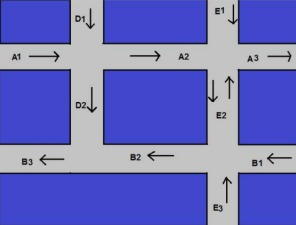

In [10]:
from IPython.display import display, Image
display(Image(filename='roads.jpeg'))

First, we construct our transition matrix. We consider roads to be continous, so if a road ends in ean dge of the map, it continues on another side of the map.

In [3]:
# Initializing roads
roads = ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'D1', 'D2', 'E1', 'E2', 'E3']
# Initializing the transition matrix
Q = [   #A1, A2, A3, B1, B2, B3, D1, D2, E1, E2, E3
        [0,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0], #A1
        [1/2, 0,  0,  0,  0,  0, 1/2, 0,  0,  0,  0], #A2
        [0,  1/2, 0,  0,  0,  0,  0,  0, 1/2,1/3, 0], #A3
        [0,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0], #B1
        [0,   0,  0, 1/2, 0,  0,  0,  0,  0, 1/3,1/2], #B2
        [0,   0,  0,  0,  1,  0,  0,  1,  0,  0,  0], #B3
        [0,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0], #D1
        [1/2, 0,  0,  0,  0,  0, 1/2, 0,  0,  0,  0], #D2
        [0,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0], #E1
        [0,  1/2,  0,1/2, 0,  0,  0,  0, 1/2, 1/3,1/2], #E2
        [0,   0,  0,  0,  0,  0,  0,  0,  0,  0,  0], #E3
]
Q = np.array(Q)

Now, lets apply the page rank method on this matrix...

In [4]:
# Applying the page rank
rank_vals = page_rank(Q)
print(rank_vals)

[0.04060583 0.07512078 0.13893331 0.04060583 0.12426445 0.21008328
 0.04060583 0.07512078 0.04060583 0.17344826 0.04060583]


In [12]:
import pyperclip
pyperclip.copy(' \\\\ \n '.join([str(val) for val in rank_vals.round(6)]))

Finally, we sort roads based on their rank values and print their rankings.

In [13]:
# Sorting webpages based on their ranking values
roads_vals = list( zip(rank_vals.tolist(), list(range(rank_vals.shape[0]))) )
sorted_by_vals = [idx for val,idx in sorted(roads_vals, reverse=True)]
# Printing road rankings
rankings = [roads[i] for i in sorted_by_vals]
print(f'Road rankings: ')
for rank, road in enumerate(rankings):
    print(f'{rank+1}) {road}')

Road rankings: 
1) B3
2) E2
3) A3
4) B2
5) D2
6) A2
7) E3
8) E1
9) D1
10) B1
11) A1



Thanks for you valuable time and attention! This notebook is available in the link below😀

https://drive.google.com/file/d/1K9HOI0ZD_11GeXh8gFx7aKU3h43zDPFh/view?usp=sharing